#### **SAGEMAKER - BYOS CONFIGURATION FOR TENSORFLOW**

In [22]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore
import tensorflow as tf
import tensorflow_io as tfio
import os
import re
import json
import seaborn as sns

from io import StringIO
from smart_open import smart_open

from IPython.core.display import display, HTML

config = botocore.config.Config()
sm = boto3.client(service_name = 'sagemaker', config = config)
sm_runtime = boto3.client('sagemaker-runtime', config = config)
sess = sagemaker.Session(sagemaker_client = sm, sagemaker_runtime_client = sm_runtime)

with open('/'.join(os.getcwd().split('/')[:-1])+'/params.json','r') as params:
    params = json.load(params)

bucket = params['sm_role']
default_bucket = sess.default_bucket()
role = params['sm_role'] #sagemaker.get_execution_role()
region = sess.boto_region_name

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

####
#### **CONFIGURE DATASET**

In [24]:
processed_csv_train = 's3://{}/data/processed/csv/train'.format(bucket)
processed_csv_validation = 's3://{}/data/processed/csv/validation'.format(bucket)
processed_csv_evaluation = 's3://{}/data/processed/csv/evaluation'.format(bucket)

In [25]:
!aws s3 cp --recursive ./data/processed/csv/train $processed_csv_train
!aws s3 cp --recursive ./data/processed/csv/validation $processed_csv_validation
!aws s3 cp --recursive ./data/processed/csv/evaluation $processed_csv_evaluation

upload: data/processed/csv/train/train.csv to s3://hwm-nba/data/processed/csv/train/train.csv
upload: data/processed/csv/validation/validation.csv to s3://hwm-nba/data/processed/csv/validation/validation.csv
upload: data/processed/csv/evaluation/evaluation.csv to s3://hwm-nba/data/processed/csv/evaluation/evaluation.csv


In [10]:
!aws s3 ls --recursive $processed_csv_train
!aws s3 ls --recursive $processed_csv_validation
!aws s3 ls --recursive $processed_csv_evaluation

2022-10-26 22:59:43     530310 data/processed/csv/train/train.csv
2022-10-26 22:59:46      59073 data/processed/csv/validation/validation.csv
2022-10-26 22:59:48      59073 data/processed/csv/evaluation/evaluation.csv


####
#### **OPTIONALLY ETL THE DATA TO THE TFRECORDS FORMAT**

In [11]:
train = pd.read_csv(smart_open(processed_csv_train+'/train.csv'))
validation = pd.read_csv(smart_open(processed_csv_validation+'/validation.csv'))
evaluation = pd.read_csv(smart_open(processed_csv_evaluation+'/evaluation.csv'))

In [12]:
def csv_to_tfrecords(data,path):
    with tf.io.TFRecordWriter(path) as file_writer:
        for i in range(len(data)): #4):
            x = data.iloc[i,:-1].to_numpy().tobytes() #[np.random.random(),np.random.random()]
            y = data.iloc[i, -1].astype('int64') #.to_numpy()  #np.random.random()
            
            mystring = tf.train.Example(features=tf.train.Features(feature={
                'x': tf.train.Feature(bytes_list=tf.train.BytesList(value=[x])),
                'y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])),
            })).SerializeToString()
            file_writer.write(mystring)

In [22]:
os.makedirs('./data/processed/tfrecords/train/', exist_ok = True)
os.makedirs('./data/processed/tfrecords/validation/', exist_ok = True)
os.makedirs('./data/processed/tfrecords/evaluation/', exist_ok = True)

In [23]:
csv_to_tfrecords(train,'./data/processed/tfrecords/train/train.tfrecords')
csv_to_tfrecords(validation,'./data/processed/tfrecords/validation/validation.tfrecords')
csv_to_tfrecords(evaluation,'./data/processed/tfrecords/evaluation/evaluation.tfrecords')

In [24]:
processed_tfrecords_train = 's3://{}/data/processed/tfrecords/train'.format(bucket)
processed_tfrecords_validation = 's3://{}/data/processed/tfrecords/validation'.format(bucket)
processed_tfrecords_evaluation = 's3://{}/data/processed/tfrecords/evaluation'.format(bucket)

In [25]:
!aws s3 cp --recursive ./data/processed/tfrecords/train $processed_tfrecords_train
!aws s3 cp --recursive ./data/processed/tfrecords/validation $processed_tfrecords_validation
!aws s3 cp --recursive ./data/processed/tfrecords/evaluation $processed_tfrecords_evaluation

upload: data/processed/tfrecords/train/train.tfrecords to s3://hwm-nba/data/processed/tfrecords/train/train.tfrecords
upload: data/processed/tfrecords/validation/validation.tfrecords to s3://hwm-nba/data/processed/tfrecords/validation/validation.tfrecords
upload: data/processed/tfrecords/evaluation/evaluation.tfrecords to s3://hwm-nba/data/processed/tfrecords/evaluation/evaluation.tfrecords


In [26]:
s3_input_train_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_csv_train
)

s3_input_validation_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_csv_validation
)

s3_input_evaluation_data = sagemaker.inputs.TrainingInput(
    s3_data = processed_csv_evaluation
)

In [27]:
data_channels = {
    'train': s3_input_train_data,
    'validation': s3_input_validation_data,
    'eval': s3_input_evaluation_data
}

####
#### **HYPERPARAMETERS**

In [28]:
seed = 42
epochs = 5
batch_size = 500
#learning_rate = 2e-5
train_batch_size = 500
#train_steps_per_epoch = 180
validation_batch_size = 500
#validation_steps_per_epoch = 20
run_validation = 1

train_instance_count = 1
train_instance_type = 'ml.m4.xlarge' #'ml.c5.9xlarge' #ml.t3.medium' #'ml.c5.9xlarge'
train_volume_size = 256
input_mode = 'File'

In [29]:
hyperparameters = {
    'epochs': epochs,
    'batch-size': batch_size,
    #'learning_rate': learning_rate,
    'train-batch-size': train_batch_size,
    #'train_steps_per_epoch': train_steps_per_epoch,
    'validation-batch-size': validation_batch_size,
    #'validation_steps_per_epoch': validation_steps_per_epoch,    
    'seed': seed,
    'run-validation': run_validation
    #'model_dir': 'opt/ml/model' #'s3://{}/outputs'.format(bucket)
}

In [30]:
# metric definitions for cloudwatch
metric_definitions = [
     {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9.]+)'}
]

####
#### **DEBUGGER RULES**

In [33]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

In [34]:
# provides options to customize how debugging information is emitted and saved

debugger_hook_config = DebuggerHookConfig(
    s3_output_path='s3://{}'.format(bucket),
)

In [35]:
# ProfilerConfig sets the configuration for collecting system and framework metrics of SageMaker Training Jobs.
# Parameter `system_monitor_interval_millis` sets the time interval to collect system metrics (in milliseconds).
# Parameter `framework_profile_params` is the object for framework metrics profiling. Here you will set its local path,
# the step at which to start profiling, `start_step`, and the number of steps to profile, `num_steps`.

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path='/opt/ml/output/profiler/', start_step=5, num_steps=10)
)

In [36]:
# For monitoring and profiling the built-in rules you can use the `ProfilerReport`.
# It creates a profiling report and updates when the individual rules are triggered.
# If you trigger this `ProfilerReport` rule without any customized parameter as in the cell below,
# then the `ProfilerReport` rule triggers all of the built-in rules for monitoring and profiling with their default parameter values.
# The profiling report can be downloaded while the Training Job is running or after the job has finished.

rules = [ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

####
#### **TRAIN MODEL USING train.py SCRIPT**

In [42]:
use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None

from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    script_mode=True,
    base_job_name = 'nba-test',
    source_dir = 'code',
    # model_dir = 's3://{}/outputs'.format(bucket),
    entry_point = 'train.py',
    role = role,
    framework_version = '2.8',
    py_version = 'py39',
    hyperparameters = hyperparameters,
    instance_count = train_instance_count,
    instance_type = train_instance_type,
    # tags = [{"Key": "Project", "Value": "cifar10"},{"Key": "TensorBoard", "Value": "dist"}],
    # distributions = distributions
    metric_definitions=metric_definitions,
    debugger_hook_config=debugger_hook_config, # what happens if we activate this?
    use_spot_instances = use_spot_instances,
    max_run=max_run,
    max_wait=max_wait
)

In [43]:
estimator.fit(
    inputs = data_channels,
    wait=False
)

In [44]:
training_job_name = estimator.latest_training_job.name
# training_job_name = estimator.latest_training_job.describe()['TrainingJobName'] #review all these keys
print('Training Job name: {}'.format(training_job_name))

Training Job name: nba-test-2022-10-27-03-22-49-611


In [47]:
training_job_status_primary = estimator.latest_training_job.describe()['TrainingJobStatus']
print('Training Job status: {}'.format(training_job_status_primary)+'\n')
print('SageMaker Training Job: https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}'.format(region, training_job_name)+'\n')
print('CloudWatch Logs: https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix'.format(region, training_job_name)+'\n')
print('S3 Output Data: https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview'.format(bucket, training_job_name, region)+'\n')


Training Job status: InProgress

SageMaker Training Job: https://console.aws.amazon.com/sagemaker/home?region=us-west-2#/jobs/nba-test-2022-10-27-03-22-49-611

CloudWatch Logs: https://console.aws.amazon.com/cloudwatch/home?region=us-west-2#logStream:group=/aws/sagemaker/TrainingJobs;prefix=nba-test-2022-10-27-03-22-49-611;streamFilter=typeLogStreamPrefix

S3 Output Data: https://s3.console.aws.amazon.com/s3/buckets/hwm-nba/nba-test-2022-10-27-03-22-49-611/?region=us-west-2&tab=overview



In [49]:
%%time
# this cell takes a while to run
estimator.latest_training_job.wait(logs=False)


2022-10-27 03:25:02 Starting - Preparing the instances for training
2022-10-27 03:25:02 Downloading - Downloading input data..............
2022-10-27 03:26:28 Training - Downloading the training image...............
2022-10-27 03:27:49 Training - Training image download completed. Training in progress.............
2022-10-27 03:28:56 Uploading - Uploading generated training model...
2022-10-27 03:29:16 Completed - Training job completed
CPU times: user 415 ms, sys: 88.9 ms, total: 504 ms
Wall time: 4min 5s


In [50]:
df_metrics = estimator.training_job_analytics.dataframe()
df_metrics

,timestamp,metric_name,value
0,0.0,validation:loss,0.29606
1,0.0,validation:accuracy,0.92200


<AxesSubplot:xlabel='timestamp'>

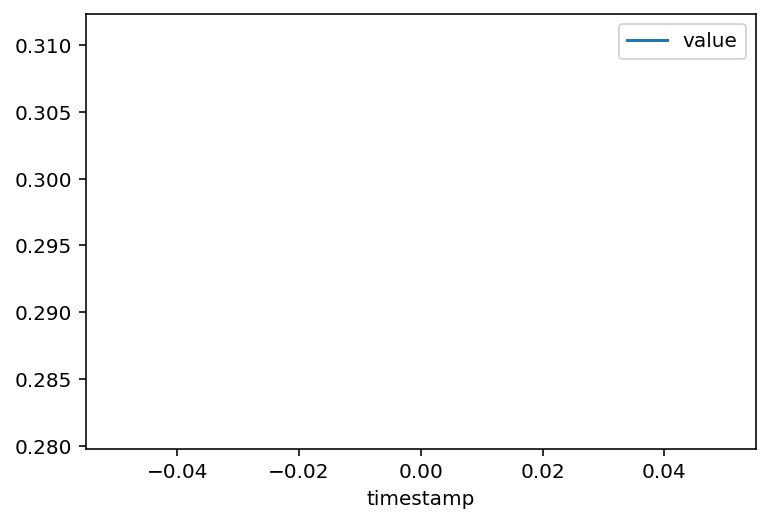

In [51]:
df_metrics.query("metric_name=='validation:loss'").plot(x='timestamp', y='value')

In [52]:
print('Debugger Output: https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/'.format(bucket, training_job_name))

Debugger Output: https://s3.console.aws.amazon.com/s3/buckets/hwm-nba?prefix=nba-test-2022-10-27-03-22-49-611/


####
#### **VIEW DEBUGGER RESULTS**

In [56]:
#!aws s3 ls $profiler_report_s3_uri/

In [53]:
s3 = boto3.Session().resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())

for my_bucket_object in my_bucket.objects.filter(Prefix=training_job_name): #.all():
    if re.search('rule-output.*profiler-output',my_bucket_object.key):
        mypath = my_bucket_object.key
        mypath = mypath.split('profiler-output/')[0]+'profiler-output/'
        break
    
profiler_report_s3_uri = ('s3://{}/'+mypath).format(sess.default_bucket())

In [54]:
profiler_report_s3_uri

's3://sagemaker-us-west-2-668209712187/nba-test-2022-10-27-03-22-49-611/rule-output/ProfilerReport-1666840970/profiler-output/'

The folder `profiler-reports` contains the built-in rule analysis components, stored in JSON and a Jupyter notebook. They are aggregated into the report.

In [59]:
!aws s3 cp --recursive $profiler_report_s3_uri ./profiler_report/
print('\nProfiler Report: ./profiler_report/profiler-report.html')

download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-27-03-22-49-611/rule-output/ProfilerReport-1666840970/profiler-output/profiler-reports/CPUBottleneck.json to profiler_report/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-27-03-22-49-611/rule-output/ProfilerReport-1666840970/profiler-output/profiler-reports/BatchSize.json to profiler_report/profiler-reports/BatchSize.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-27-03-22-49-611/rule-output/ProfilerReport-1666840970/profiler-output/profiler-reports/GPUMemoryIncrease.json to profiler_report/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-27-03-22-49-611/rule-output/ProfilerReport-1666840970/profiler-output/profiler-reports/MaxInitializationTime.json to profiler_report/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-west-2-668209712187/nba-test-2022-10-27-03-22-49-611

####
#### **DEPLOYING THE MODEL**

In [61]:
from sagemaker.tensorflow.serving import TensorFlowModel #Model

tensorflow_serving_model = TensorFlowModel(
    model_data = estimator.model_data,
    role = role,
    framework_version = '2.8', # version 2.8 appears to be the latest compatible - can review this later
    sagemaker_session = sess,
    source_dir = 'code',
    entry_point = 'inference.py'
)

input_data_path = processed_csv_evaluation
output_data_path = 's3://hwm-nba/test-predictions'
batch_instance_count = 1
batch_instance_type = 'ml.m4.xlarge'
concurrency = 1  # can we make this higher and not waste on fees?
max_payload_in_mb = 1

transformer = tensorflow_serving_model.transformer(
    instance_count=batch_instance_count,
    instance_type=batch_instance_type,
    max_concurrent_transforms=concurrency,
    max_payload=max_payload_in_mb,
    output_path=output_data_path,
    strategy='MultiRecord' # so we can process many test examples at once
)

In [62]:
transformer.transform(data=input_data_path, content_type = 'text/csv')
transformer.wait()

.............................INFO:__main__:PYTHON SERVICE: True
INFO:__main__:starting services
INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: 'model'
    base_path: '/opt/ml/model'
    model_platform: 'tensorflow'
    model_version_policy: {
      specific: {
        versions: 1
      }
    }
  }
}
INFO:__main__:tensorflow version info:
TensorFlow ModelServer: 2.8.3-rc1+dev.sha.no_git
TensorFlow Library: 2.8.3
INFO:__main__:tensorflow serving command: tensorflow_model_server --port=10000 --rest_api_port=10001 --model_config_file=/sagemaker/model-config.cfg --max_num_load_retries=0    
INFO:__main__:started tensorflow serving (pid: 14)
INFO:tfs_utils:Trying to connect with model server: http://localhost:10001/v1/models/model
2022-10-27 03:43:10.679881: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2022-10-27 03:43:10.680318: I tensorflow_serving/model_servers/serve

In [63]:
!aws s3 cp --quiet --recursive $transformer.output_path ./test_predictions

In [64]:
preds = pd.DataFrame([v[0] for v in json.load(open('./test_predictions/evaluation.csv.out'))['predictions']])
preds['pred'] = np.round(preds[0]).astype(int)

ground_truth = pd.read_csv('./data/processed/csv/evaluation/evaluation.csv')
preds = pd.concat([ground_truth,preds],axis=1)

In [65]:
preds['accuracy'] = preds.apply(lambda x: 1 if x['is_orange']==x['pred'] else 0,axis=1)

In [66]:
sum(preds['accuracy'])

929

Text(0.5, 1.0, 'Confusion Matrix')

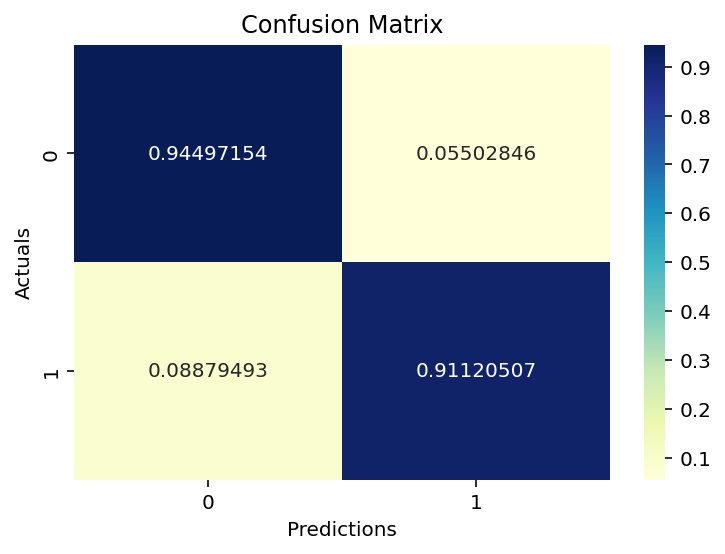

In [67]:
confusion_matrix = pd.crosstab(
    preds['is_orange'],
    preds['pred'],
    rownames=['Actuals'],
    colnames=['Predictions'],
    normalize='index',
)
sns.heatmap(confusion_matrix, annot = True, fmt = '.8f', cmap = 'YlGnBu').set_title('Confusion Matrix')

In [69]:
%%time

endpoint_name = 'nba-sexy-endpoint'

predictor = estimator.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.m4.xlarge',
    endpoint_name = endpoint_name
    #update_endpoint = None
    #accelerator_type = 'ml.eia1.medium' # only works with certain versions of tensorflow! (< 2.8?)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


------!CPU times: user 171 ms, sys: 39.3 ms, total: 210 ms
Wall time: 3min 3s


In [70]:
print('Review Endpoint: https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}'.format(region, endpoint_name))

Review Endpoint: https://console.aws.amazon.com/sagemaker/home?region=us-west-2#/endpoints/nba-sexy-endpoint


####
#### **TESTING ON UNSEEN DATA**

In [71]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer,JSONSerializer,JSONLinesSerializer
from sagemaker.deserializers import JSONDeserializer,JSONLinesDeserializer

class CSVPredictor(Predictor):
    def __init__(self, endpoint_name, sess):
        super().__init__(endpoint_name,
                         sagemaker_session=sess,
                         serializer=CSVSerializer(),
                         deserializer=JSONDeserializer())

In [72]:
predictor = CSVPredictor(endpoint_name, sess)

In [73]:
inputs = pd.read_csv('./data/processed/csv/train/train.csv',header=None).reset_index().iloc[:,1:].to_numpy()
inputs

array([['diameter', 'weight', 'red', 'green', 'blue', 'is_orange'],
       ['0.706449222', '0.721602289', '0.636363636', '0.270588235',
        '0.0', '0'],
       ['0.4306894', '0.402174535', '0.532467532', '0.764705882',
        '0.018518519', '1'],
       ...,
       ['0.563380282', '0.548555079', '0.350649351', '0.447058824',
        '0.407407407', '0'],
       ['0.740548554', '0.76211731', '0.467532468', '0.305882353', '0.0',
        '0'],
       ['0.440326168', '0.413962804', '0.376623377', '0.364705882',
        '0.0', '1']], dtype=object)

In [74]:
predicted_classes = predictor.predict(inputs)

In [75]:
len(predicted_classes['predictions'])

9000

In [76]:
for predicted_class in predicted_classes['predictions'][:10]:
    print("Predicted class {} with probability {}".format(int(np.round(predicted_class[0])),np.round(2*np.abs(0.5-predicted_class[0]),5), ))

Predicted class 0 with probability 0.87869
Predicted class 1 with probability 0.92592
Predicted class 0 with probability 0.86401
Predicted class 1 with probability 0.98502
Predicted class 0 with probability 0.43914
Predicted class 1 with probability 0.93661
Predicted class 0 with probability 0.71067
Predicted class 1 with probability 0.42648
Predicted class 1 with probability 0.68581
Predicted class 0 with probability 0.06539


In [77]:
preds = [np.round(v[0]) for v in predicted_classes['predictions']]

ground_truth = pd.read_csv('./data/processed/csv/train/train.csv')
preds = pd.concat([ground_truth,pd.DataFrame(preds,columns=['pred'])],axis=1)

In [78]:
preds

,diameter,weight,red,green,blue,is_orange,pred
0,0.706449,0.721602,0.636364,0.270588,0.000000,0,0.0
1,0.430689,0.402175,0.532468,0.764706,0.018519,1,1.0
2,0.633062,0.637082,0.493506,0.435294,0.240741,0,0.0
3,0.243884,0.190844,0.636364,0.647059,0.055556,1,1.0
4,0.546331,0.528298,0.376623,0.400000,0.000000,0,0.0
...,...,...,...,...,...,...,...
8995,0.428466,0.399313,0.350649,0.635294,0.000000,1,1.0
8996,0.512973,0.500715,0.441558,0.717647,0.222222,1,1.0
8997,0.563380,0.548555,0.350649,0.447059,0.407407,0,0.0
8998,0.740549,0.762117,0.467532,0.305882,0.000000,0,0.0


Text(0.5, 1.0, 'Confusion Matrix')

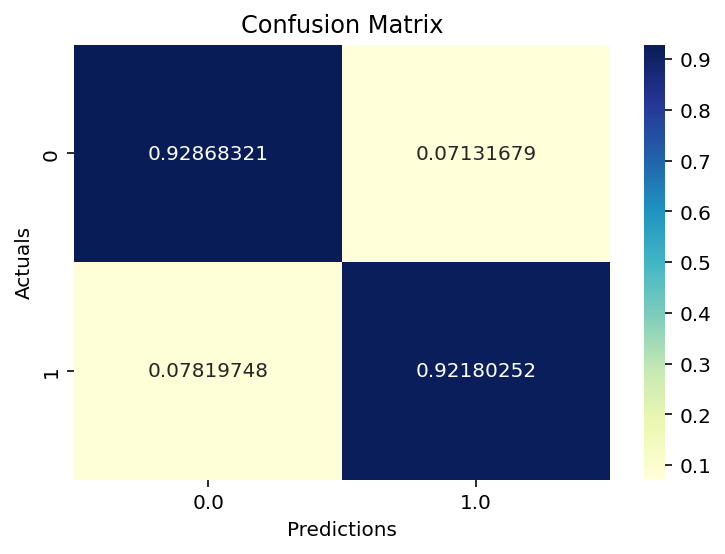

In [79]:
confusion_matrix = pd.crosstab(
    preds['is_orange'],
    preds['pred'],
    rownames=['Actuals'],
    colnames=['Predictions'],
    normalize='index',
)
sns.heatmap(confusion_matrix, annot = True, fmt = '.8f', cmap = 'YlGnBu').set_title('Confusion Matrix')

In [80]:
sess.delete_endpoint(predictor.endpoint_name)